In [7]:
#Set up DrWatson
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
# Load relevant fuctions
include("/home/jm2386/Active_Lattice/src/pm_pde_functions.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");
include("/home/jm2386/Active_Lattice/src/plot_functions.jl");

function animate_phase_pdes_pm(param,t_saves,fa_saves,fp_saves; frames = 99, ϕg = 0.0, ϕl = 1.0)
    @unpack name, λ, ρa, ρp, Nx, Nθ, δt, Dθ, χ, γ = param
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    N = length(t_saves)
    function makeframe(i)
        clf()
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        axs = ax1, ax2
        vid_pde_plot_pm(fig, axs, param, t_saves, fa_saves, fp_saves, i+1)
        binod_liquid = ax1.plot((1:Nx)/Nx, ϕl*ones(Nx), color = "black", linestyle = "--", label = "_liquid phase")
        binod_gas = ax1.plot((1:Nx)/Nx, ϕg*ones(Nx), color = "black",linestyle = "--", label = "_gas phase")
        return fig
    end
    interval = 5*Int64(round(20000/frames))
    myanim = anim.FuncAnimation(fig, makeframe, frames=frames, interval=interval)
    # Convert it to an MP4 movie file and saved on disk in this format.
    T = t_saves[Int64(round((frames+1)))]
    pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/vids/pde_phase_vids/$(name)/active=$(ρa)_passive=$(ρp)_lamb=$(λ)";
    mkpath(pathname)
    filename = "/store/DAMTP/jm2386/Active_Lattice/plots/vids/pde_phase_vids/$(name)/active=$(ρa)_passive=$(ρp)_lamb=$(λ)/time=$(round(T; digits = 5))_Nx=$(Nx)_Nθ=$(Nθ)_active=$(ρa)_passive=$(ρp)_lamb=$(λ).mp4";
    myanim[:save](filename, bitrate=-1, dpi= 100, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

function make_phase_video_pm(param; skip_factor = 10, ϕg = 0.0, ϕl = 1.0,start_time = 0.)
    @unpack T, save_interval = param
    save_interval = save_interval*skip_factor
    t_saves, fa_saves, fp_saves = load_pdes_pm(param,T; save_interval = save_interval, start_time = start_time)
    frames = Int64(length(t_saves))
    animate_phase_pdes_pm(param,t_saves,fa_saves,fp_saves; frames = frames-1,ϕg =ϕg, ϕl = ϕl)
end

function vid_pde_plot_pm(fig::Figure, axs, param::Dict{String,Any}, t_saves, fa_saves, fp_saves, i)
    @unpack Nx, Nθ, ρa, ρp, χ, Dθ, Dx, k, γ,Pe = param
    ρa_saves, ρp_saves = deepcopy(spatial_density_pm.(fa_saves)), deepcopy(fp_saves)

    push!(ρa_saves[i], ρa_saves[i][1])
    push!(ρp_saves[i], ρp_saves[i][1])

    ρsum = ρp_saves[i]+ρa_saves[i]

    axs[1].plot((0:1:Nx)/Nx,ρa_saves[i], color = "red", label = L"\rho^a")
    axs[1].plot((0:1:Nx)/Nx,ρsum, color = "black", label = L"\rho")
    axs[1].plot((0:1:Nx)/Nx,ρp_saves[i], color = "blue", label = L"\rho^p")

    axs[1].xaxis.set_ticks(0.:0.2:1.0)
    axs[1].xaxis.set_tick_params(labelsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    rhomax = maximum(maximum(ρa_saves))+maximum(maximum(ρp_saves))
    axs[1].axis([0., 1., 0. , rhomax])
    #axs[1].axis([0., 1., min(minimum(minimum(ρa_saves)),minimum(minimum(ρp_saves))),maximum(maximum( ρa_saves+ρp_saves ))])
    axs[1].set_xlabel(L"x",fontsize=20)
    #axs[1].set_ylabel(L"\rho,",fontsize=20)
    title = latexstring("\$ \\ell = $(round(1/sqrt(Dθ); digits = 2)), \\chi = $(χ), \\phi = $(ρa+ρp), \\mathrm{Pe} = $(round(Pe; digits = 3)), t = $(round(t_saves[i]; digits = 3))\$")
    axs[1].set_title(title,fontsize=20)

    mat1 = zeros(1, Nx+1)
    mat2= zeros(1, Nx+1)
    mags = mag_pm(fa_saves[i]; Nθ = Nθ)
    push!(mags,mags[1])
    mat1[1, :] = mags
    mat2[1, :] = mags.*(-ρsum.+1)

    #colmap = PyPlot.plt.cm.seismic
    colmap = PyPlot.plt.cm.PRGn
    norm1 = matplotlib.colors.Normalize(vmin= -rhomax*0.5 , vmax= rhomax*0.5) 
    #norm1 = matplotlib.colors.Normalize(vmin= -maximum(abs.(mags)) , vmax= maximum(abs.(mags)) )
    #norm2 = matplotlib.colors.Normalize(vmin= minimum(mags/10) , vmax= maximum(mags)/10 )

    axs[2].matshow(mat1; norm = norm1,  cmap = colmap, extent = [0., 1., 0., 0.1])
    #axs[3].matshow(mat2; norm = norm2,  cmap = colmap, extent = [0., 1., 0., 0.1])

    axs[2].set_aspect(1.)
    #axs[3].set_aspect(1.)

    axs[2].xaxis.set_ticks(0.:0.2:1.0)
    axs[2].yaxis.set_ticks([])
    axs[2].xaxis.set_tick_params(labelsize=15)
    axs[2].xaxis.tick_bottom()
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    #ax.set_xlabel(L"x",fontsize=20)

    axs[2].set_ylabel(L"\mathbf{p}", fontsize=20, rotation=0)
    axs[2].yaxis.set_label_coords(-.05, .5)

    lines, labels = axs[1].get_legend_handles_labels()
    fig.tight_layout()
    ldg = fig.legend(lines, labels, loc = "center right", fontsize=20, bbox_to_anchor = (0.25, 0.25, 1, 1),
    bbox_transform = plt.gcf().transFigure)

    return fig
end

function vid_pde_plot_pm_plus(fig::Figure, axs, param::Dict{String,Any}, t_saves, fa_saves, fp_saves, i)
    @unpack Nx, Nθ, ρa, ρp, χ, Dθ, Dx, k, γ,Pe = param
    ρa_saves, ρp_saves = deepcopy(spatial_density_pm.(fa_saves)), deepcopy(fp_saves)

    ja_saves, jp_saves = deepcopy(spatial_currents_pm(fa_saves, fp_saves; param = param))

    push!(ja_saves[i], ja_saves[i][1])
    push!(jp_saves[i], jp_saves[i][1])

    push!(ρa_saves[i], ρa_saves[i][1])
    push!(ρp_saves[i], ρp_saves[i][1])

    ρsum = ρp_saves[i]+ρa_saves[i]

    axs[1].plot((0:1:Nx)/Nx,ρa_saves[i], color = "red", label = L"\rho^a")
    axs[1].plot((0:1:Nx)/Nx,ρsum, color = "black", label = L"\rho")
    axs[1].plot((0:1:Nx)/Nx,ρp_saves[i], color = "blue", label = L"\rho^p")

    axs[1].xaxis.set_ticks(0.:0.2:1.0)
    axs[1].xaxis.set_tick_params(labelsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    rhomax = maximum(maximum(ρa_saves))+maximum(maximum(ρp_saves))
    axs[1].axis([0., 1., 0. , rhomax])
    #axs[1].axis([0., 1., min(minimum(minimum(ρa_saves)),minimum(minimum(ρp_saves))),maximum(maximum( ρa_saves+ρp_saves ))])
    axs[1].set_xlabel(L"x",fontsize=20)
    #axs[1].set_ylabel(L"\rho,",fontsize=20)
    title = latexstring("\$ \\ell = $(round(1/sqrt(Dθ); digits = 2)), \\chi = $(χ), \\phi = $(ρa+ρp), \\mathrm{Pe} = $(round(Pe; digits = 3)), t = $(round(t_saves[i]; digits = 3))\$")
    axs[1].set_title(title,fontsize=20)

    mat1 = zeros(1, Nx+1)
    mat2= zeros(1, Nx+1)
    mags = mag_pm(fa_saves[i]; Nθ = Nθ)
    push!(mags,mags[1])
    mat1[1, :] = mags
    mat2[1, :] = mags.*(-ρsum.+1)

    #colmap = PyPlot.plt.cm.seismic
    colmap = PyPlot.plt.cm.PRGn
    norm1 = matplotlib.colors.Normalize(vmin= -rhomax*0.5 , vmax= rhomax*0.5) 
    #norm1 = matplotlib.colors.Normalize(vmin= -maximum(abs.(mags)) , vmax= maximum(abs.(mags)) )
    #norm2 = matplotlib.colors.Normalize(vmin= minimum(mags/10) , vmax= maximum(mags)/10 )

    axs[2].matshow(mat1; norm = norm1,  cmap = colmap, extent = [0., 1., 0., 0.1])
    #axs[3].matshow(mat2; norm = norm2,  cmap = colmap, extent = [0., 1., 0., 0.1])

    axs[2].set_aspect(1.)
    #axs[3].set_aspect(1.)

    axs[2].xaxis.set_ticks(0.:0.2:1.0)
    axs[2].yaxis.set_ticks([])
    axs[2].xaxis.set_tick_params(labelsize=15)
    axs[2].xaxis.tick_bottom()
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    #ax.set_xlabel(L"x",fontsize=20)

    axs[2].set_ylabel(L"\mathbf{p}", fontsize=20, rotation=0)
    axs[2].yaxis.set_label_coords(-.05, .5)


    axs[3].plot((0:1:Nx)/Nx, ja_saves[i], color = "red", label = L"j^a")
    axs[3].plot((0:1:Nx)/Nx, jp_saves[i], color = "blue", label = L"j^p")

    jmax = maximum(maximum(ja_saves))+maximum(maximum(jp_saves))
    axs[3].xaxis.set_ticks(0.:0.2:1.0)
    axs[3].xaxis.set_tick_params(labelsize=15)
    axs[3].yaxis.set_tick_params(labelsize=15)
    axs[3].axis([0., 1., -jmax , jmax])
    axs[3].set_xlabel(L"x",fontsize=20)


    lines, labels = axs[1].get_legend_handles_labels()
    fig.tight_layout()
    ldg = fig.legend(lines, labels, loc = "center right", fontsize=20, bbox_to_anchor = (0.25, 0.25, 1, 1),
    bbox_transform = plt.gcf().transFigure)

    return fig
end

vid_pde_plot_pm_plus (generic function with 1 method)

In [2]:
# parameters
Pe = 7.5;
initial_Δ = 1e-4;
max_iter = 40;
tol = 1e-3;
atol = 1e-12;
rho_max = (1-10e-20);

In [198]:
#quick solve
Pe = 7.5;
γ_limit = find_gamma_limit(;Pe = Pe, initial_Δ = initial_Δ, γ_max = 100.)
γ = 1.9 # γ_limit-0.00001
find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol)
gamma_converter(γ, lower_limits[1])

(0.4561127797358473, 0.2576307885461776)

In [184]:
#set Γ range
Γ = collect(1:0.01:γ_limit)
for i in 3:1:10
    γ1 = round(γ_limit, RoundDown; digits= i-1)
    γ2 = round(γ_limit, RoundDown; digits= i)
    Γ = append!(Γ,collect(γ1:(10.0^(-i)):γ2))
end
println(Γ)

[1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.1400000000000001, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.3599999999999999, 1.37, 1.38, 1.3900000000000001, 1.4, 1.4100000000000001, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.5899999999999999, 1.6, 1.6099999999999999, 1.62, 1.63, 1.6400000000000001, 1.65, 1.6600000000000001, 1.67, 1.6800000000000002, 1.69, 1.7000000000000002, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.8399999999999999, 1.85, 1.8599999999999999, 1.87, 1.88, 1.8900000000000001, 1.9, 1.9100000000000001, 1.92, 1.9300000000000002, 1.94, 1.9500000000000002, 1.96, 1.97, 1.98, 1.99, 2.0, 2.01, 2.02, 2.0300000000000002, 2.04, 2.05, 2.06, 2.0700000000000003, 2.08, 2.09, 2.1, 2.1100000000000003, 2.12, 2.13, 2.14, 2.1500000000000004, 2.16, 2.17, 2.1799999999999997, 2.

In [185]:
#solve over Γ
Pes = []
    γs = []
    ϕ1s = []
    ϕ2s = []
    approx = []
    errors = []
for γ in Γ
    find_sol = false
    try 
        find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol)
        if find_sol
            push!(ϕ1s,lower_limits[1])
            push!(ϕ2s,upper_limits[1])
            push!(γs, γ)
        end
    catch
            println("no solution Pe=$(Pe), γ=$(γ)")
            push!(errors,γ)
    end
end
average_ϕs = (ϕ1s+ ϕ2s)./2
χs = chis_converter(γs, average_ϕs)

#save results
using JLD2
    data = Dict{String,Any}()
    @pack! data = Pe, γs, ϕ1s, ϕ2s, average_ϕs, χs
    filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
    wsave(filename,data)

In [3]:
#load binodal
filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
data = wload(filename)
@unpack Pe, γs, ϕ1s, ϕ2s, average_ϕs, χs = data

Dict{String, Any} with 6 entries:
  "γs"         => Any[1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09…
  "average_ϕs" => [0.553688, 0.55902, 0.564251, 0.569385, 0.574425, 0.579373, 0…
  "ϕ1s"        => Any[0.161048, 0.171849, 0.18245, 0.192857, 0.203078, 0.213115…
  "χs"         => [1.0, 0.992112, 0.984555, 0.977312, 0.970365, 0.9637, 0.95730…
  "Pe"         => 7.5
  "ϕ2s"        => Any[0.946328, 0.946191, 0.946053, 0.945913, 0.945772, 0.94563…

In [15]:
#plot binodal
using PyPlot
PyPlot.close("all")
rc("text", usetex=true)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
binod = ax.plot(gammas_converter_a(γs, ϕ1s), gammas_converter_p(γs, ϕ1s), color = "red", label = "Binodal")
ax.plot(gammas_converter_a(γs, ϕ2s), gammas_converter_p(γs, ϕ2s), color = "red", label = "_Bindoal")
ax.plot(0.:0.1:1., 1.:-0.1:0., color = "black", label = "_Full")

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa0b589ba30>

In [16]:
#plot tie lines
γ_length = length(γs)
n_lines = 40
interval = Int(round(γ_length/n_lines))
Δx = 0.001

x_values = -collect( ϕ1s[interval]:Δx:ϕ2s[interval] ).+1
γ = γs[interval]
ax.plot(-γ*x_values.+1, (γ-1)*x_values, color = "gray", label = "Tie line")
for i in (3*interval):(2*interval):Int64(round(γ_length))
    γ = γs[i]
    ϕa, ϕp = gamma_converter(γ, ϕ1s[i])
    stable1 = is_stable_value(ϕa, ϕp; Pe = Pe)
    ϕa, ϕp = gamma_converter(γ, ϕ2s[i])
    stable2  = is_stable_value(ϕa, ϕp; Pe = Pe)
    stable = (stable1<0)&(stable2<0)
    x = -collect(ϕ1s[i]:Δx:ϕ2s[i]).+1
    if stable
        colour = "gray"
    else
        colour = "black"
    end
    ax.plot(-γ*x.+1, (γ-1)*x, color = colour, label = "_cloud line")
end

In [11]:
#plot spinodal
ϕas = collect(0.0001:0.0001:0.999)
    ϕa_sols, low_ϕps, high_ϕps = return_complex_boundary_outer(ϕas; Pe = Pe)
    n = length([x for x in ϕa_sols if x < 0.42])
    N = length(ϕa_sols)
    ax.plot(ϕa_sols[1:n], low_ϕps[1:n], color = "green", label = "Complex")
    ax.plot(ϕa_sols[1:n], high_ϕps[1:n], color = "green", label = "_Complex")
    ax.plot(ϕa_sols[(n+1):1:N], low_ϕps[(n+1):1:N], color = "green", label = "_Complex")
    ax.plot(ϕa_sols[(n+1):1:N], high_ϕps[(n+1):1:N], color = "green", label = "_Complex")


    ϕa_sols, low_ϕps1, high_ϕps1, low_ϕps2, high_ϕps2 = return_complex_boundary_inner(ϕas; Pe = Pe)
    ax.plot(ϕa_sols, low_ϕps1, color = "green", label = "_Complex")
    ax.plot(ϕa_sols, high_ϕps1, color = "green", label = "_Complex")
    ax.plot(ϕa_sols, low_ϕps2, color = "green", label = "_Complex")
    ax.plot(ϕa_sols, high_ϕps2, color = "green", label = "_Complex")
    
    ϕa_low, ϕa_high, low_ϕps2, high_ϕps2 = return_stable_boundary(ϕas; Pe = Pe)
    ax.plot(ϕa_low, low_ϕps2, color = "blue", label = "Spinodal")
    ax.plot(ϕa_high, high_ϕps2, color = "blue", label = "_Spindoal")

    ϕa_low, ϕa_mid, ϕa_high, low_ϕps, mid_ϕps, high_ϕps = return_stable_boundary_extra(ϕas; Pe = Pe)
    ax.plot(ϕa_low, low_ϕps, color = "blue", label = "_Spinodal")
    ax.plot(ϕa_high, high_ϕps, color = "blue", label = "_Spindoal")
    ax.plot(ϕa_mid, mid_ϕps, color = "blue", label = "_Spindoal")

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa0b59ad760>

In [151]:
# #plot fake spinodal
# #ϕas = collect(0.0001:0.01:0.999)
# ϕa_pts, ϕp_pts = fake_spin_boundary(ϕas; Pe = Pe)
# ax.plot(ϕa_pts, ϕp_pts, color = "black", linestyle = "--", label = "_Complex")
# #fake_spin_pt(0.4; Pe = Pe)
# #println(fake_spin_pt(0.49; Pe = 20.))

# #fake_spin_boundary([0.6]; Pe = Pe)
# #minimum(ϕa_pts)

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f328444deb0>

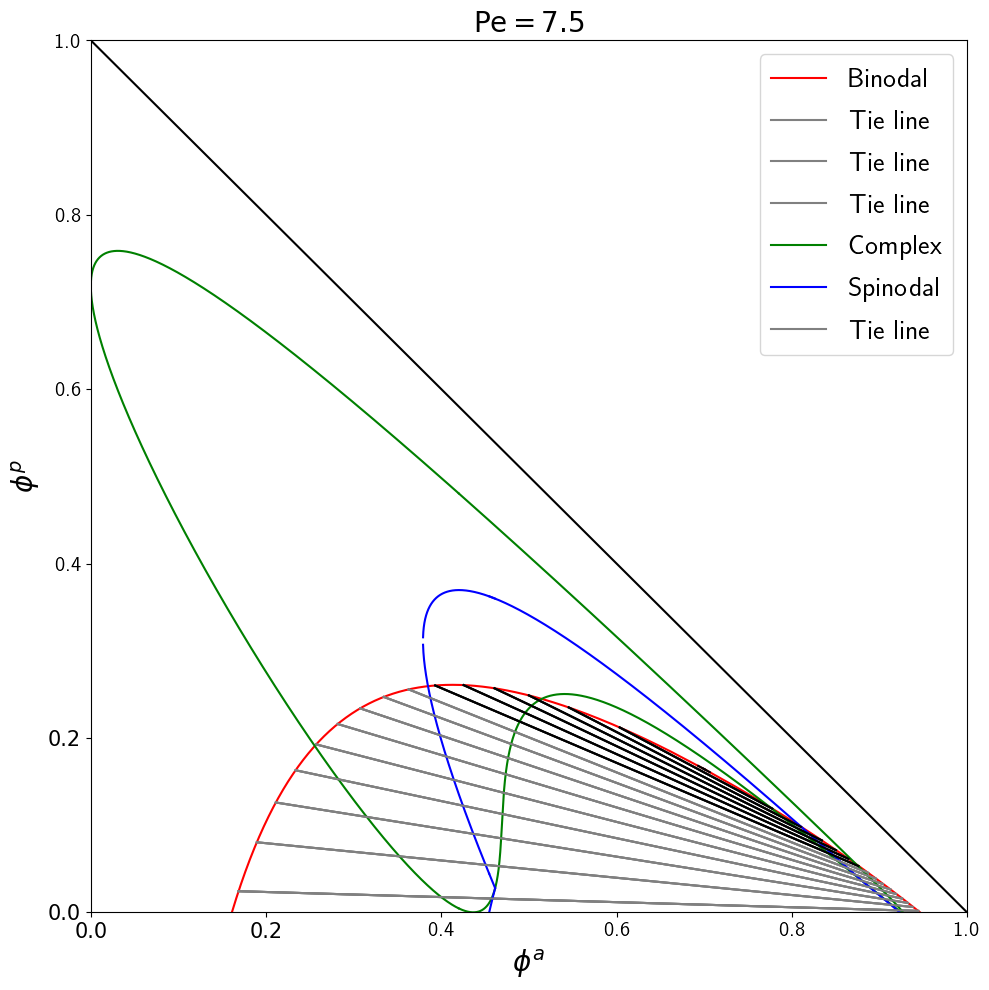

In [14]:
#fig options
rc("text", usetex=true)
    #ax.yaxis.set_ticks(ytic)
    axlim = [0, 1, 0, 1]
    #axlim = [0.4, 0.45, 0, 0.1]
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_xlabel(L"\phi^a",fontsize=20)
    ax.set_ylabel(L"\phi^p", fontsize=20)
    ax.legend(loc = "upper right", fontsize=20)
    #ax.set_aspect(0.25*Δρ/ΔPe)
    title = latexstring("\$ \\mathrm{Pe} = $(Pe)\$")
    ax.set_title(title,fontsize=20)
    fig.tight_layout()
display(fig)

In [ ]:
#save figure
name = "BinSpin_Pe=$(Pe)"
    pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/active_passive_1d/$(name)";
    mkpath(pathname)
    filename = "/store/DAMTP/jm2386/Active_Lattice/plots/active_passive_1d/$(name)/BinSpin.pdf";
    PyPlot.savefig(filename,dpi = 100, format = "pdf") #bbox_extra_artists=( ldg,)

In [14]:
# set parameters
ρ = 0.3+0.5
χ = 0.5/ρ
Pe = 7.5
pert = "rand"
    T  = 4.0
    δ  = 1e-2
    save_interval = 0.01
    Dx = 1. 
    Dθ = 10000.0
    Nx = 512
    Nθ = 2
name = "pm_pde_run_δ=$(δ)_l=$(1/sqrt(Dθ))"
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = 1e-5, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
                        )






Dict{String, Any} with 31 entries:
  "λs"            => 20.0:20.0:100.0
  "T"             => 4.0
  "video_length"  => 10000.0
  "save_interval" => 0.01
  "max_runs"      => 6
  "Pe"            => 7.5
  "λ_step"        => 10.0
  "δ"             => 0.01
  "Nθ"            => 2
  "name"          => "pm_pde_run_δ=0.01_l=0.01"
  "δt"            => 1.0e-5
  "λ"             => 750.0
  "Dθ"            => 10000.0
  "cbar_max"      => 1.0
  "Dx"            => 1.0
  "cbar_min"      => 0.0
  "Nx"            => 512
  "k"             => 20
  "pert"          => "rand"
  ⋮               => ⋮

In [ ]:
#run pde
perturb_pde_run_pm(param)

In [13]:
#make vid
make_phase_video_pm(param; frames = 100)

/store/DAMTP/jm2386/Active_Lattice/data/pde_raw/article_pde_run_1d_δ=0.01_l=0.01/Nx=512_Nθ=2_active=0.5_passive=0.30000000000000004_lamb=750.0_dt=1.0e-5_Dθ=10000.0/time=0.01_Nx=512_Nθ=2_active=0.5_passive=0.30000000000000004_lamb=750.0_dt=1.0e-5_Dθ=10000.0.jld2
/store/DAMTP/jm2386/Active_Lattice/data/pde_raw/pm_pde_run_δ=0.01_l=0.01/Nx=512_Nθ=2_active=0.5_passive=0.30000000000000004_lamb=750.0_dt=1.0e-5_Dθ=10000.0/time=0.01_Nx=512_Nθ=2_active=0.5_passive=0.30000000000000004_lamb=750.0_dt=1.0e-5_Dθ=10000.0.jld2


In [2]:
Pe = 7.5
pert = "pm_lin"
    T = 0.05
    save_interval = 0.001
    δ  = 1e-4
    Dx = 1. 
    Dθ = 400.0
    Nx = 2^10
    Nθ = 2
    δt = 1e-8
#
#load binodal values
name = "pm_pde_binodal_run_δ=$(δ)_l=$(1/sqrt(Dθ))"
#
filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
data = wload(filename)
@unpack Pe, γs, ϕ1s, ϕ2s, average_ϕs, χs = data
#create params
params = []
γ_length = length(γs)
n_lines = 40
interval = Int(round(γ_length/n_lines))
γs          = γs[interval:(interval):Int64(round(γ_length))]
average_ϕs  = average_ϕs[interval:(interval):Int64(round(γ_length))]
map(average_ϕs, γs) do ρ, γ
        χ = (1-γ*(1-ρ))/ρ
        param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = δt, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
        )
        push!(params,param)
end

38-element Vector{Vector{Any}}:
 [Dict{String, Any}("λs" => 20.0:20.0:100.0, "T" => 0.05, "video_length" => 10000.0, "save_interval" => 0.001, "max_runs" => 6, "Pe" => 7.5, "λ_step" => 10.0, "δ" => 0.0001, "Nθ" => 2, "name" => "pm_pde_run_δ=0.0001_l=0.05"…), Dict{String, Any}("λs" => 20.0:20.0:100.0, "T" => 0.05, "video_length" => 10000.0, "save_interval" => 0.001, "max_runs" => 6, "Pe" => 7.5, "λ_step" => 10.0, "δ" => 0.0001, "Nθ" => 2, "name" => "pm_pde_run_δ=0.0001_l=0.05"…), Dict{String, Any}("λs" => 20.0:20.0:100.0, "T" => 0.05, "video_length" => 10000.0, "save_interval" => 0.001, "max_runs" => 6, "Pe" => 7.5, "λ_step" => 10.0, "δ" => 0.0001, "Nθ" => 2, "name" => "pm_pde_run_δ=0.0001_l=0.05"…), Dict{String, Any}("λs" => 20.0:20.0:100.0, "T" => 0.05, "video_length" => 10000.0, "save_interval" => 0.001, "max_runs" => 6, "Pe" => 7.5, "λ_step" => 10.0, "δ" => 0.0001, "Nθ" => 2, "name" => "pm_pde_run_δ=0.0001_l=0.05"…), Dict{String, Any}("λs" => 20.0:20.0:100.0, "T" => 0.05, "video_len

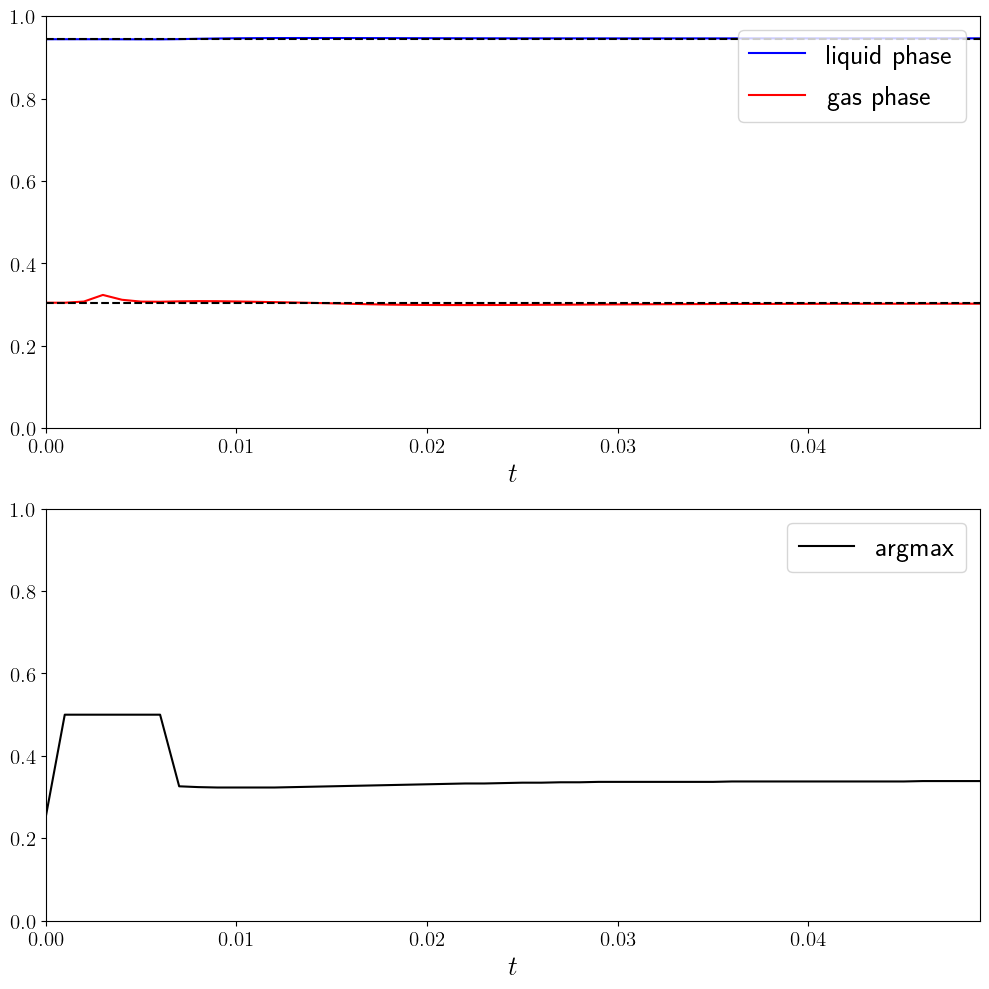

In [43]:

param = params[4]

function cal_rho_saves(fa, fp; Nθ = Nθ)
    return fp + sum(fa; dims =2)[:,1]
end

function time_plot_peak_density(param)
    # load solution

    @unpack save_interval, T, ρa, ρp = param

    t_saves, fa_saves, fp_saves = load_pdes_pm(param,T; save_interval = save_interval);

    if t_saves == []
        println("load error, no saves found")
    else
        ρ_saves = cal_rho_saves.(fa_saves, fp_saves; Nθ = Nθ);
        ρl_saves =  maximum.(ρ_saves);
        ρg_saves =  minimum.(ρ_saves);
        xmax_saves = argmax.(ρ_saves)/Nx;
        #plot binodal

        # parameters
        Pe = 7.5;
        γ = (1-ρa)/(1-ρa-ρp)
        initial_Δ = 1e-4;
        max_iter = 40;
        tol = 1e-16;
        atol = 1e-16;
        rho_max = (1-10e-20);

        find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
        ϕg = lower_limits[1]
        ϕl = upper_limits[1]

        ax = axs[1]
            N = length(t_saves)
            liquid = ax.plot(t_saves, ρl_saves, color = "blue", label = "liquid phase")
            gas = ax.plot(t_saves, ρg_saves, color = "red", label = "gas phase")
            binod_liquid = ax.plot(t_saves, ϕl*ones(N), color = "black", linestyle = "--", label = "_liquid phase")
            binod_gas = ax.plot(t_saves, ϕg*ones(N), color = "black",linestyle = "--", label = "_gas phase")
            #plot phase
            ax = axs[2]
        ax.plot(t_saves, xmax_saves, color = "black", label = "argmax")

        #axs settings
        for ax in axs
            #ax.yaxis.set_ticks(ytic)
            axlim = [0, maximum(t_saves), 0, 1]
            #axlim = [0.4, 0.45, 0, 0.1]
            ax.xaxis.set_tick_params(labelsize=15)
            #ax.xaxis.tick_bottom(t_saves)
            ax.yaxis.set_tick_params(labelsize=15)
            ax.axis(axlim)
            #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
            ax.set_xlabel(L"t",fontsize=20)
            #ax.set_ylabel(L"\phi^p", fontsize=20)
            ax.legend(loc = "upper right", fontsize=20)
            #ax.set_aspect(0.25*Δρ/ΔPe)
        end
        fig.tight_layout()
    end
end

using PyPlot
    PyPlot.close("all")
    rc("text", usetex=true)
fig, axs = plt.subplots(2, 1, figsize=(10,10))
time_plot_peak_density(param)
display(fig)

In [44]:
@unpack ρa, ρp, Pe = param
    γ = (1-ρa)/(1-ρa-ρp)
    initial_Δ = 1e-4;
    max_iter = 40;
    tol = 1e-16;
    atol = 1e-16;
    rho_max = (1-10e-20);

    find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
ϕg = lower_limits[1]
ϕl = upper_limits[1]

make_phase_video_pm(param; skip_factor = 1, ϕg = ϕg, ϕl = ϕl)

In [18]:
param = params[15]

density  = initialize_sol_pm_full(param)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/jm2386/.julia/packages/SciMLBase/kTUaf/src/integrator_interface.jl:580


Dict{String, Any} with 3 entries:
  "t"  => 0.0
  "fa" => [0.167189 0.167189; 0.167189 0.167189; … ; 0.167189 0.167189; 0.16718…
  "fp" => [0.246992, 0.246992, 0.246992, 0.246992, 0.246992, 0.246992, 0.246992…

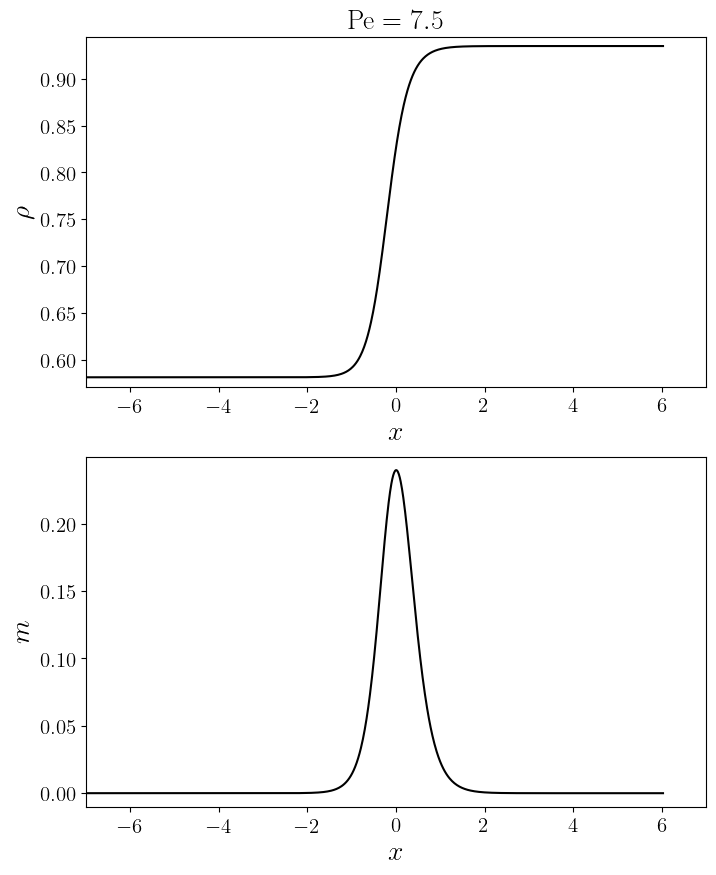

374
13.964859353158712


In [42]:
param = params[4]

#compute solution
J = zeros(2,2)
u = zeros(2)
parameters = (Pe, γ, ϕg, ϕl)
t = 0.
J = f_jac(J,u,parameters,t)
values, vectors = eigen(J)
evector2 = vectors[:,2]

ff = ODEFunction(f;jac=f_jac)
ϵ = 1e-15
initial_position = [ϕg, 0.0] + ϵ*evector2
time_interval = (0.0, 15.0)

ff = ODEFunction(f;jac=f_jac)
prob = ODEProblem(ff,initial_position,time_interval, parameters)

sol = DifferentialEquations.solve(prob,abstol = 1e-14, reltol = 1e-14);

#find central time
t_mid_arg = argmax(sol[2,:])
t_middle = sol.t[t_mid_arg]
t_max = maximum(sol.t[:].-t_middle)
t_min = minimum(sol.t[:].-t_middle)
t_lim = round(min(t_max, - t_min))
t_lim_index = argmin(abs.(sol.t[:].-2*t_lim))
println(t_lim_index)
println(sol.t[t_lim_index])
#plot figure
PyPlot.close("all")
fig, axs = plt.subplots(2, 1, figsize=(8,10))
xlabels = [L"\rho", L"m"]
for i in 1:2
    ax = axs[i]
    ax.plot(sol.t[1:t_lim_index].-t_middle, sol[i,1:t_lim_index], color = "black")
    axlim = [ -t_lim, t_lim, minimum(sol[i,1:t_lim_index])-0.01, maximum(sol[i,1:t_lim_index])+0.01]
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_ylabel(xlabels[i],fontsize=20)
    ax.set_xlabel(L"x",fontsize=20)
end
fig_title = latexstring("\$ \\mathrm{Pe} = $(Pe) \$")
axs[1].set_title(fig_title,fontsize=20)
display(fig)